##Descrição da Base De Dados

Nossa base de dados de 10k linhas, e é sobre a venda de carros, nela temos 3 variáveis independentes/features:

- Price/preco
  - É o valor em dólares do valor do carro.

- Modelo Year/ Ano do Modelo
 - Como o nome já explica, é o ano do lançamento do modelo de carro.

- Mileage Per Year/ Milhas por ano
  - Como o nome já sugere, é a quantidade de milhas que essa carro andou em média por ano.

Dentro da nossa base de dados temos uma variável qualitativa/dependente, que é a variável Sold:

- Sold/Vendido
  - Variável Qaulitativa binária, que mostra se o modelo de carro foi vendido ou não.

In [ ]:
import pandas as pd

uri = 'https://gist.githubusercontent.com/guilhermesilveira/4d1d4a16ccbf6ea4e0a64a38a24ec884/raw/afd05cb0c796d18f3f5a6537053ded308ba94bf7/car-prices.csv'
dados = pd.read_csv(uri, sep = ",")
dados

,Unnamed: 0,mileage_per_year,model_year,price,sold
0,0,21801,2000,30941.02,yes
1,1,7843,1998,40557.96,yes
2,2,7109,2006,89627.50,no
3,3,26823,2015,95276.14,no
4,4,7935,2014,117384.68,yes
...,...,...,...,...,...
9995,9995,15572,2006,97112.86,no
9996,9996,13246,2002,107424.63,yes
9997,9997,13018,2014,93856.99,no
9998,9998,10464,2011,51250.57,yes


#Tratando os dados

vamos traduzir nossa base de dados e excluir a coluna indice que veio a mais:

In [ ]:
dados.pop("Unnamed: 0")
dados.rename(columns = {"mileage_per_year":"Milhas_Por_Ano", "model_year":"Ano_Do_Modelo",
                        "price":"Preco", "sold":"Vendido"}, inplace = True)
dados.Vendido = dados.Vendido.map({"yes":1, "no":0}, )
dados

,Milhas_Por_Ano,Ano_Do_Modelo,Preco,Vendido
0,21801,2000,30941.02,1
1,7843,1998,40557.96,1
2,7109,2006,89627.50,0
3,26823,2015,95276.14,0
4,7935,2014,117384.68,1
...,...,...,...,...
9995,15572,2006,97112.86,0
9996,13246,2002,107424.63,1
9997,13018,2014,93856.99,0
9998,10464,2011,51250.57,1


Veja a transformação que fizemos na coluna Vendido, veja que nela não traduzimos, nela transformamos os campos Strings em bináirios! Isso porque a maioria dos modelo de classificação de variáveis binárias, exigie que essa variável binária seja na forma booleana!

Adora vamos realizar transformações da unidade de medida, vamos transformar milhas para kilómetos e vamos alterar o campo Ano De Modelo para Idade Do Modelo, Para isso vamos subtrair o ano atual pelo ano do modelo:

In [ ]:
#Trannsformação milha para quiilometro
# 1 milha  = 1.609 quilometros

dados["Milhas_Por_Ano"] = dados.Milhas_Por_Ano * 1.609
dados.rename(columns = {"Milhas_Por_Ano":"Quilometros_Por_Ano"}, inplace = True)

#Tranformação de Ano de Modelo para Idade
from datetime import datetime
ano_atual = datetime.today().year

dados.Ano_Do_Modelo = ano_atual - dados.Ano_Do_Modelo
dados.rename(columns = {"Ano_Do_Modelo":"Idade"}, inplace = True)


dados

,Quilometros_Por_Ano,Idade,Preco,Vendido
0,35077.809,22,30941.02,1
1,12619.387,24,40557.96,1
2,11438.381,16,89627.50,0
3,43158.207,7,95276.14,0
4,12767.415,8,117384.68,1
...,...,...,...,...
9995,25055.348,16,97112.86,0
9996,21312.814,20,107424.63,1
9997,20945.962,8,93856.99,0
9998,16836.576,11,51250.57,1


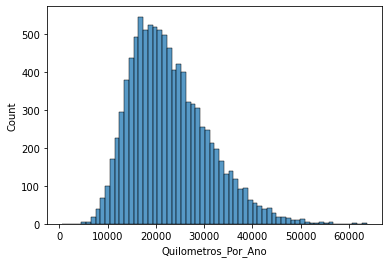

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.histplot(dados.Quilometros_Por_Ano)

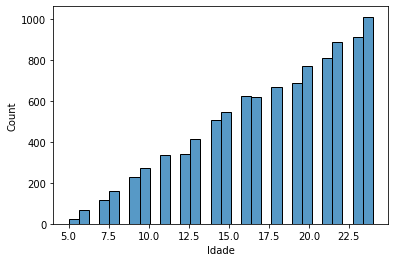

In [ ]:
sns.histplot(dados.Idade)

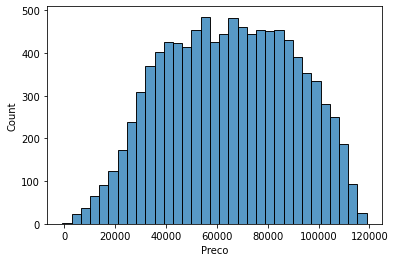

In [ ]:
sns.histplot(dados.Preco)

Podemos ver que tirando a variável idade, as demais variáveis explicativas tem distribuição normal. vamos analisar o gráfico 3D das 3variáveis juntas

In [ ]:
!pip3 install ipympl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Text(0.5, 0, 'Quilometros Por Ano')

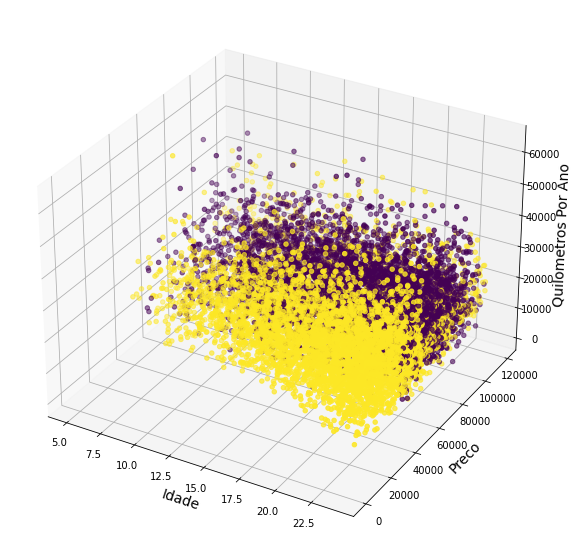

In [ ]:
#Devemos rodar esse código para habilitar a opcao dentro do colab, para que se plote graficos 3d interativos
%matplotlib widget
from google.colab import output
output.enable_custom_widget_manager()

#Definindo os 3 eixos

x = dados.Idade
y = dados.Preco
z = dados.Quilometros_Por_Ano

fig = plt.figure()
fig.set_size_inches(16,10)

grafico = fig.add_subplot(111, projection = "3d")

grafico.scatter(x,y, z, c= dados.Vendido,  )
grafico.set_xlabel("Idade", fontsize = 14)
grafico.set_ylabel("Preco", fontsize = 14)
grafico.set_zlabel("Quilometros Por Ano", fontsize = 14)

Conseguimos perceber que existe um região do espaço onde existem somemente pontos (carros) vendidos, que a região de rexo. Vamos usar o modelo de classificação de máquina de vetores de suporte não linear para traçar Hipleplanos nesse plano tridimencional que separa as classes:

#Máquina de Vetores De Suporte Não Linear - SVM

Como já foi visto, para que possamos aplicar hipeplano não lineares devemos padronizar as variáveis explicativas/features numa mesma escala! Vamos fazer isso:

In [ ]:
x = dados[["Idade", "Preco", "Quilometros_Por_Ano"]]
y = dados["Vendido"]

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import numpy as np

SEED = 10
np.random.seed(SEED)

x_treino_raw, x_teste_raw, y_treino, y_teste = train_test_split(x, y, stratify= y, test_size=0.25)

escala = StandardScaler()
escala.fit(x_treino_raw)
x_treino = escala.transform(x_treino_raw)
x_teste = escala.transform(x_teste_raw)

Visualizando a nova escala:

In [ ]:
print("Preco padronizado: ", x_treino[:,1].max(), x_treino[:,1].min())
print("Preco NAO padronizado: ", x_treino_raw["Preco"].max(), x_treino_raw["Preco"].min())

Preco padronizado:  2.1562982589352 -2.5900396114382844
Preco NAO padronizado:  118929.72 -840.36


Veja que, para a variável Preco que antes tinha a maior escala entre as variáveis explicativas, agora nossa escala fica entre [2.5,-2.5]

Vamos treinar nosso modelo de máquinas de vetores de suporte não linear com as features padronizadas:

In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, confusion_matrix

modelo_vendas_svm = SVC(gamma = "auto")
modelo_vendas_svm.fit(x_treino, y_treino)
previsoes_vendas_svm = modelo_vendas_svm.predict(x_teste)

acuracia = accuracy_score(previsoes_vendas_svm, y_teste)*100
print("Acurácia do modelo svm : %.2f%%" % acuracia)

Acurácia do modelo svm : 75.84%


In [ ]:
confusion_matrix(y_teste, previsoes_vendas_svm)

array([[ 785,  265],
       [ 339, 1111]])

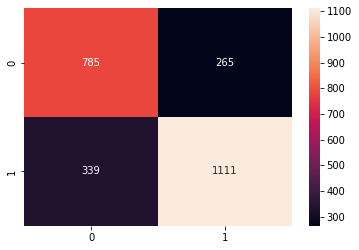

In [ ]:
sns.heatmap(confusion_matrix(y_teste, previsoes_vendas_svm), annot = True, fmt="d")
#sns.heatmap(confusion_matrix(y_teste, previsoes_sites), annot = True, fmt="d"  )

#Comparando com Modelos Dummys/Bobos

Mas benévolo, será que 75% de acurácia realmente é um número bom para este problema? A maioria das pessoas pensaria que é sim... Mas sempre devemos comprar a acurácia do nosso modelo com a acurácia do modelo "bobo", isto é, comparar com a acurácia do modelo do chute!

Aqui vem o 2 grande erro... Pensar que a acurácia do modelo do chute sempre será próximo de 50%... Isso nem sempre é certo, aliás, somente será correto se a probabilidade de sucesso e fracasso forem 50%, que é o caso do lançamento da moeda.

2 caracteristicas podem mudar essa probaiblidade de 50%:

- Dados desbalanceados.
  - Se na minha base de dados eu tenho mais exemplos de um classe do que de outra, naturalmente a acurácia do chute vai tender acertar mais para os casos que estão na classe majoritária.

 - As probabilidades de sucesso e fracasso são diferentes, logo existe uma maior probabilidade de ocorrencia para uma das classes.

Por esses motivos, existem casos onde o teste com o modelo Bobo = Dummy pode passar de 50%. Agora vamos instanciar um modelo Dummy/Bobo já pronto do sklearn que foi feito justamente para essa comparação! O modelo se chama DummyClassifier e ele sempre terá as mesma probabilidades de chute para cada classe dentro da variável denepenete.

Existem vários tipos de classificadores Dummy, mas o mais usados são dois:

- DummyClassifier stratificado.
 - Como o nome já sugere, ele vai levar em conta o desbalaceamento de classes dentro da variável dependente Y. Por exemplo, se eu tiver um desbalanceamento de 70% para 0 e 30% para 1, o classificador Dummy vai ter para seu chute, uma probabilidade de 70% de classificar como 0 e uma probabilidade de 30% de classificar como 1.
 - Isse ajuste do modelo, faz com que o modelo Bobo não seja tão bobo (mais ainda é bobo, pois esse modelo para treinar apenas conta a porcetagem de desbalanço das classes), logo ele tende a acertar mais que o modelo que chuta tudo 1 ou tudo 0.
 - Se nosso modelo que é mais rebuscado não conseguir ser melhor que este modelo simplista, podemos afirmar que nosso modelo não é eficás.



- DummyClassifier Most Frequent
  - Neste caso, o nosso modelo faz um contagem de frequência das classificações dentro da variável  dependente Y e a classificação que tem  a maior frequência é escolhida para o chute fixo. Isto é, somente iremos fazer uma classificação.
  - Por exemplo, se eu tiver mais 1 que 0 no meu Y, o DummyClassifier vai chutar tudo 1. Veja que também é um modelo de classificação bobo, mas... É mais inteligente (acerta mais) que somente chutar 1 ou 0 com 50% para cada um.

Vamos utilizar os dois:

In [ ]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier(strategy = "stratified")
dummy_stratified.fit(x_treino, y_treino)
previsoes_dummy = dummy_stratified.predict(x_teste)

acuracia = accuracy_score(y_teste, previsoes_dummy)*100
print("Acuracia modelo Dummy Stratified : %.2f%%" % acuracia)

Acuracia modelo Dummy Stratified : 52.72%


In [ ]:
from sklearn.dummy import DummyClassifier

dummy_stratified = DummyClassifier(strategy = "most_frequent")
dummy_stratified.fit(x_treino, y_treino)
previsoes_dummy = dummy_stratified.predict(x_teste)

acuracia = accuracy_score(y_teste, previsoes_dummy)*100
print("Acuracia modelo Dummy Stratified : %.2f%%" % acuracia)

Acuracia modelo Dummy Stratified : 58.00%


Podemos ver que, o classificar dummy com maior acurácia é de maior frequência. Logo nosso modelo de Máquina de Vetores de Suporte deve ter uma acurácia maior que ela, o que de fato tem, ele tem 75% de acurácia!

#Arvore de Decisão - Classificador

benévolo, se eu te perguntasse quais são os passos exatos que o modelo de classificação de Máquina de Vetores de Suporte faz para classificar os dados você conseguiria?

Bom, suspeito que a resposta é.... "Tenho um noção, posso te explicar por cima... Existe um hiperplano calculado sobre os vetores e se o ponto estiver de algum lado do hiperplano ele será classificado conforme o plano que pertence..."

Benévolo, essa explicação é uma explicação que chamamos de BlackBox - Caixa Preta- , pois não temos controle absoluto de como o algoritmo faz, isto é, não sabemos os passos exatos que nosso algoritmo toma para chegar na classificaçao final!

Pensando nisso surgiram modelos que nos mostram passo a passo, todo o processo de tomada de decisão do modelo de machine learning para que se chegue na classificação, esse modelos se chamam de Modelos De Arvore de Decisão. Veja benévolo, Arvore De Decisão é um conjunto de modelos que tem essa caracteristica e não somente um modelo em especifico.

Lógico que existe um modelo de Árvore de Decisão Padrão, e é esse que vamos estudar agora.

A biblioteca sklearn já tem uma classe de arvore de decisão que vamos importar, que é DecisionTreeClassifier. Para nossa alegria, o modelo de Árvore De Decissão não pede que os dados estejam padronizados, logo podemos usar os dados na escala original deles.

In [ ]:
x

,Idade,Preco,Quilometros_Por_Ano
0,22,30941.02,35077.809
1,24,40557.96,12619.387
2,16,89627.50,11438.381
3,7,95276.14,43158.207
4,8,117384.68,12767.415
...,...,...,...
9995,16,97112.86,25055.348
9996,20,107424.63,21312.814
9997,8,93856.99,20945.962
9998,11,51250.57,16836.576


In [ ]:
y

0       1
1       1
2       0
3       0
4       1
       ..
9995    0
9996    1
9997    0
9998    1
9999    0
Name: Vendido, Length: 10000, dtype: int64

Vamos colocar em uma única célula a separação dos dados em treino e teste, separando eles estratificado em relação a Y e com o SEED do numy setado:

In [ ]:
from sklearn.model_selection import train_test_split
import numpy as np

SEED = 10
np.random.seed(SEED)

x_treino, x_teste, y_treino, y_teste = train_test_split(x, y, stratify = y)

Vamos instanciar o modelo de Árvore de Decisão padrão e já vamos treinar e fazer previões com ela numa mesma célula:

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score

modelo_arvore = DecisionTreeClassifier()
modelo_arvore.fit(x_treino, y_treino)

previsoes_arvore = modelo_arvore.predict(x_teste)

acuracia_arvore = accuracy_score(previsoes_arvore, y_teste)*100
print("Acuracia da Arvore de Decisao : %.2f%%" % acuracia_arvore)

Acuracia da Arvore de Decisao : 71.08%


71% É uma boa acurácia, se comparada com a acurácia do modelo Dummy que foi de 58%  

Agora vamos visualizar extamente o que queremos ver, vamos visualizar a Árvore de Decisão! Para isso vamos usar duas bibliotecas:

- sklearn.tree export_graphviz
  - É o método que efetivamente vai gerar o gráfico mas.. que não plota. Para plotar ele de fato necessitamos do graphviz puro:

- graphviz
  - è um biblioteca que precisamos instalar e importar, pois ela não vem nativamente no python, como as bibliotecas sklearn, pandas, numpy....
  - Vale ressaltar que devemos instalar ela usando !pip e também digitando !apt-get install graphviz, pois ele instala o graphviz na linha de comando do notebook.

 método dentro da biblioteca sklearn.tree usado expecialmente para a plotagem gráfica da Árvore De Decisão:

In [ ]:
!pip install graphviz==0.20
!apt-get install graphviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Reading package lists... Done
Building dependency tree       
Reading state information... Done
graphviz is already the newest version (2.40.1-2).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 4 not upgraded.


In [ ]:
from sklearn.tree import export_graphviz
import graphviz

dot_data = export_graphviz(modelo_arvore, out_file=None)
grafico_arvore = graphviz.Source(dot_data)
grafico_arvore

Benévolo, veja que nossa árvore de decisão é gigante, ela tem uma profundidade muito grande. O fato dela ter uma profudidade muito grande tem os seguinte impacto no modelo:

- A interpretação gráfica da árvore de decisão se perde. Quanto mais profunda for nossa árove de decisão mais difícil será sua interpretação.
  - Benévolo, este é o nosso caso, dúvido você iterpretar o que está desenhado na imagem acima....

- Uma árvore de decisão com uma profundidade grande não necessáriamente terá uma acurácia maior que uma árvore de decisão com uma profundidade menor (com os mesmo dados de treino).
   - Ou seja, não existe relação direta entre a profundidade da árvore com a acurácia do modelo de árvore!

Benévolo, o segundo tópico, que é o que afirma que não podemos fazer erra correlação positiva entre a profundidade da árvore a sua acurácia, merece nossa atenção... Vamos diminuir a profundidade da nossa árvore modelada para testar essa afirmação:

In [ ]:
modelo_arvore = DecisionTreeClassifier(max_depth = 2)
modelo_arvore.fit(x_treino, y_treino)

previsoes_arvore = modelo_arvore.predict(x_teste)

acuracia_arvore = accuracy_score(previsoes_arvore, y_teste)*100
print("Acuracia da Arvore de Decisao : %.2f%%" % acuracia_arvore)

Acuracia da Arvore de Decisao : 75.40%


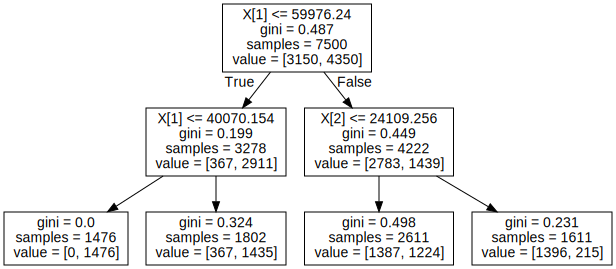

In [ ]:
dot_data = export_graphviz(modelo_arvore, out_file=None)
grafico_arvore = graphviz.Source(dot_data)
grafico_arvore

benévolo, veja o que ocorreu acima! Além de termos reduzido nossa profundidade para 2 (a raiz é nivel 0) aumentamos nossa acurácia! Veja que de fato, nossa Ärvore De Decisão com 2 nívies de profundidade tem uma acurácia maior que a antiga Árvore De Decisão de profundidade muito maior!

Note que agora conseguimos ver de forma comprendível a nossa Árvore de Decisão. Mas ainda existem palavras dentro de cada folha que não conseguimos compreender. Vamos explicar cada uma:

- X[n] + expreção lógica
  - É a coluna dentro dos dados de treino X, para nosso contexto temos a seguinte relação:
  - X[0] = Idade
  - X[1] = Preco
  - X[2] = Quilometros Por Ano


- Samples
  - É a quantidade de linhas que se encaixam anexpreção lógica que está na primeira linha da folha (X{n})


- Value
  - Mostra quantos elementos (linhas) tem de cada classe naquela amostra(sample)..

- Gini
  - Proposto em 1912 pelo estatístico italiano Corrado Gini, o índice GINI é uma medida bastante conhecida e utilizada [10]. Ele é um índice de dispersão estatística que mede a heterogeneidade dos dados e é utilizado tanto para a seleção de atributos como também em análises econômicas e sociais para verificar a distribuição de renda em um certo país.
  - Aqui no Contexto de Árvores de Decisão, o índice de Gini é usado para medir a Heterogenidade dos dados dentro do sample.
  - Quando este índice é igual a zero, o conjunto de dados é puro, ou seja, todos os registros pertencem a uma mesma classe.
  - Por outro lado, quando ele se aproxima do valor um, o conjunto apresenta os registros distribuídos igualmente entre todas as classes.
  - Ou seja, quanto mais perto de 0 o índice de Gini for, maior será a acurácia daquele nó folha!

Podemos subtituir os valores X[n] pelo nome das coluna proriamente dito, isso nos ajuda a ver e interpretar de forma mais o gráfico de Árvore de Decisão. para isso, basta passar um parâmetro a mais no método export_graphviz(), passamos o parâmetros Feature_Names = , e passamos o nomes das colunas na ordem que estão no dados de treino X:

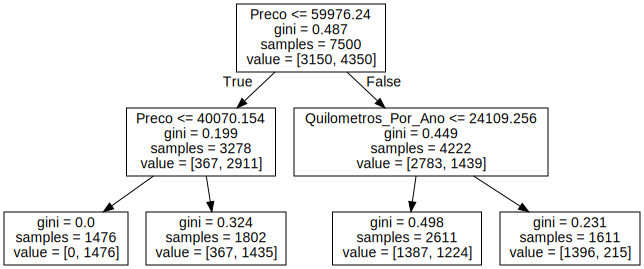

In [ ]:
dot_data = export_graphviz(modelo_arvore, out_file=None, feature_names = x.columns)
grafico_arvore = graphviz.Source(dot_data)
grafico_arvore

Ainda podemos melhorar a interface gráfica da nossa árvore, vamos adicionar dois elementos muito comuns, vamos colorir as folhas conforme a "Certeza da Classificação", ou seja, coforme mais perto de 0 o índice de Gini for, mais forte será a cor da folha, ou seja, quanto mais perto de 1 for o índice de Gine para aquela folha, mais embranquiçado será a sua cor (menos forte).

Vamos adicionar um novo campo a cada nó/folha que conterá a classificação que ele está fazendo para aquele conjunto de dados no sample.

Colorindo e arrendodando:

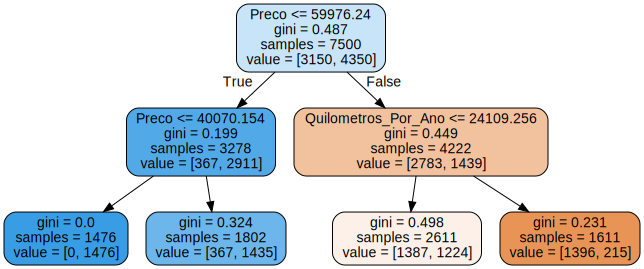

In [ ]:
dot_data = export_graphviz(modelo_arvore, out_file=None, feature_names = x.columns, filled = True, rounded = True)
grafico_arvore = graphviz.Source(dot_data)
grafico_arvore

Adicionando classe

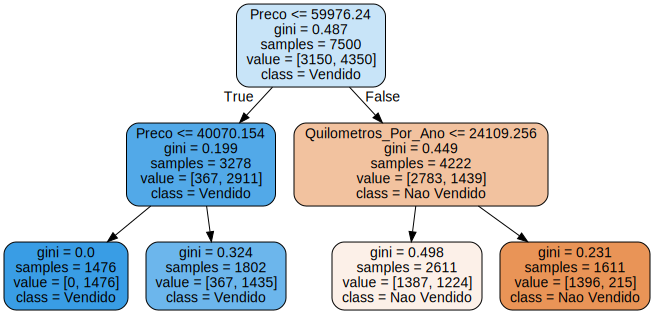

In [ ]:
dot_data = export_graphviz(modelo_arvore, out_file=None, feature_names = x.columns, filled = True, rounded = True, class_names = ["Nao Vendido", "Vendido"])
grafico_arvore = graphviz.Source(dot_data)
grafico_arvore

#Interpretando a árvore de decisão

O que a imagem acima nos diz é o seguinte, começando da raiz:


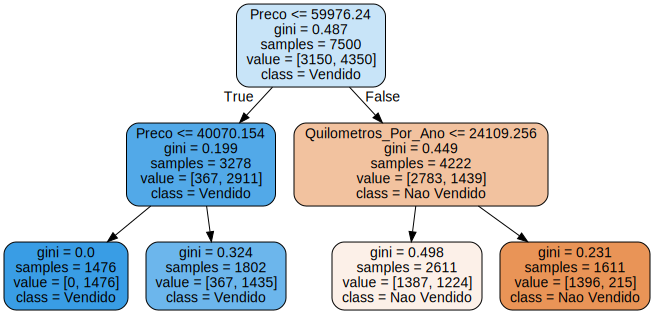

In [ ]:
dot_data = export_graphviz(modelo_arvore, out_file=None, feature_names = x.columns, filled = True, rounded = True, class_names = ["Nao Vendido", "Vendido"])
grafico_arvore = graphviz.Source(dot_data)
grafico_arvore

- Nó raiz
  - Ele está usando todos os dados dentro de X_TESTE, pois o sample = 7500.
  - O gini = 0,487, logo dentro do sample (que é todo conjunto x_teste) não existem uma homogenidade de classes 1 (vendido) ou 0 (não vendido).
  - Nesta etapa de divisão de elementos, existem 3150 lementos que a árvore classificaria como sendo 0- Não Vendido e 4350 como sendo 1-Vendido, isso é mostrado no campo value[3150,4350].
    - Note que, é nesta etapa de classificação no sentido de que, se a arvore tivesse somente o nível raiz, ele faria essa classificação.
    - A cor azulada clara dela reflete o valor de Gine para essa amostra/sample, que é alto, gini = 0.487, ou seja, nesta etapa (com esse sample/amostra) ele não tem uma certeza forte se a classificação que está fazendo nessa etapa é boa.
    - A soma dessas classes sempre dará o valor do sample/amostra, o que faz todo sentido. Neste nó temos 3150 + 4350 = 7500
  - Expressão lógica: Preco < 59976.24
    -  Essa é uma expressão lógica que será aplicada no sample/amostra atual e que vai dividir essa amostra/sample nos nós filhos dependendo do valor de reposta para expressão lógica.

- Nó filho Esquerdo - nível 1
   - É o que recebe todos os elementos que retornaram True para a expressão lógica do nó pai.
   - Sample = 3278, ou seja, dos 7500 do sample do nó pai, 3278 retornaram True para a expressão lógica do nó pai.
   - A cor azul mais acentuado reflete o índice de Gini menor que a do pai, gini = 0.199, ou seja, ele tem uma maior certeza que o nó pai, que a classificação para Vendido - 1, será mais acertiva.
   - Neste nó, a classificaçao desses 3278 seria: 367 classificados como  0-Não Vendido e 2911 classificdos como 1-Vendido, e é o que o campo value[367, 2911] está nos mostrando.
   - índice Gini = 0.19 reflete essa diferença entre as classificaçoes: value[367, 2911], veja que, o indice gini estar próximo de 0 significa que o sample/amostra está mais próxima de estar homogênia, ou seja, mais próxima de ter apenas uma classificação.

   


- Nó filho Direito - nível 1
  - Ele vai receber todos os elementos que retornaram False para a expressão lógica do nó pai.
  - Sample = 4222 significa que 4222 elementos retoranaram False para a expressão lógica do nó pai.
  - Value[2783, 1439] indica que, destes 4222 da amostra/sample, 27783 serão classificados com sendo Não vendido - 0, e 1439 seria classificado com Vendid - 1.
  - Gini = 0.449, mostra essa heterogenidade de classificação dentro da amostra/sample, pois veja a diferença entre os valores 2783, 1439 não é substancialmente grande.
  - A cor e tonalidade refelte o tipo de classificação e o indicie de gini. Isto é, a cor laranja significa que a classificação desse sample seria Não Vendido e o indice de gini ser alto (menos certeza) refleta na tonalidade da cor.

- Análise nós folhas (finais)
  - Devemos notar que:
    - A soma dos samples de todos os nós folhas deve dar o sample total, ou seja, no nosso exemplo dará 7500, o que faz todo sentido.
    - o caso ótimo é quando todos os nós folhas tem o indice gini = 0... Isso significa que, no final (depois que todo algoritmo rodar) os dados inicias (7500 no exemplo) cairam em subgrupos onde somente há dados de uma classe (samples homogêneos, onde gini= 0).

#Ajustando a profundidade

Benévolo, existe um número de profundidade da árvore de decisão ótimo, onde o algoritmo de árvore de decisão alcança sua máxima acurácia! Como este é o primeiro curso de árvore de decisão que damos, não temos prentenção de estimar matemáticamente qual é o valor dessa profundidade ótima, aqui vamos ir no teste impírico mesmo:

Acurácia com profundidade = 3

In [ ]:
modelo_arvore = DecisionTreeClassifier(max_depth = 3)
modelo_arvore.fit(x_treino, y_treino)

previsoes_arvore = modelo_arvore.predict(x_teste)

acuracia_arvore = accuracy_score(previsoes_arvore, y_teste)*100
print("Acuracia da Arvore de Decisao : %.2f%%" % acuracia_arvore)

Acuracia da Arvore de Decisao : 78.36%


In [ ]:
modelo_arvore = DecisionTreeClassifier(max_depth = 4)
modelo_arvore.fit(x_treino, y_treino)

previsoes_arvore = modelo_arvore.predict(x_teste)

acuracia_arvore = accuracy_score(previsoes_arvore, y_teste)*100
print("Acuracia da Arvore de Decisao : %.2f%%" % acuracia_arvore)

Acuracia da Arvore de Decisao : 78.36%


In [ ]:
modelo_arvore = DecisionTreeClassifier(max_depth = 5)
modelo_arvore.fit(x_treino, y_treino)

previsoes_arvore = modelo_arvore.predict(x_teste)

acuracia_arvore = accuracy_score(previsoes_arvore, y_teste)*100
print("Acuracia da Arvore de Decisao : %.2f%%" % acuracia_arvore)

Acuracia da Arvore de Decisao : 77.96%


In [ ]:
modelo_arvore = DecisionTreeClassifier(max_depth = 6)
modelo_arvore.fit(x_treino, y_treino)

previsoes_arvore = modelo_arvore.predict(x_teste)

acuracia_arvore = accuracy_score(previsoes_arvore, y_teste)*100
print("Acuracia da Arvore de Decisao : %.2f%%" % acuracia_arvore)

Acuracia da Arvore de Decisao : 77.44%


Benévolo, vemos que nossa profundidade ótima parece ser 4, com 78,36% de acurácia. Vamos plotar a árvore de decisão dela:

In [ ]:
modelo_arvore = DecisionTreeClassifier(max_depth = 4)
modelo_arvore.fit(x_treino, y_treino)

previsoes_arvore = modelo_arvore.predict(x_teste)

acuracia_arvore = accuracy_score(previsoes_arvore, y_teste)*100
print("Acuracia da Arvore de Decisao : %.2f%%" % acuracia_arvore)

Acuracia da Arvore de Decisao : 78.36%


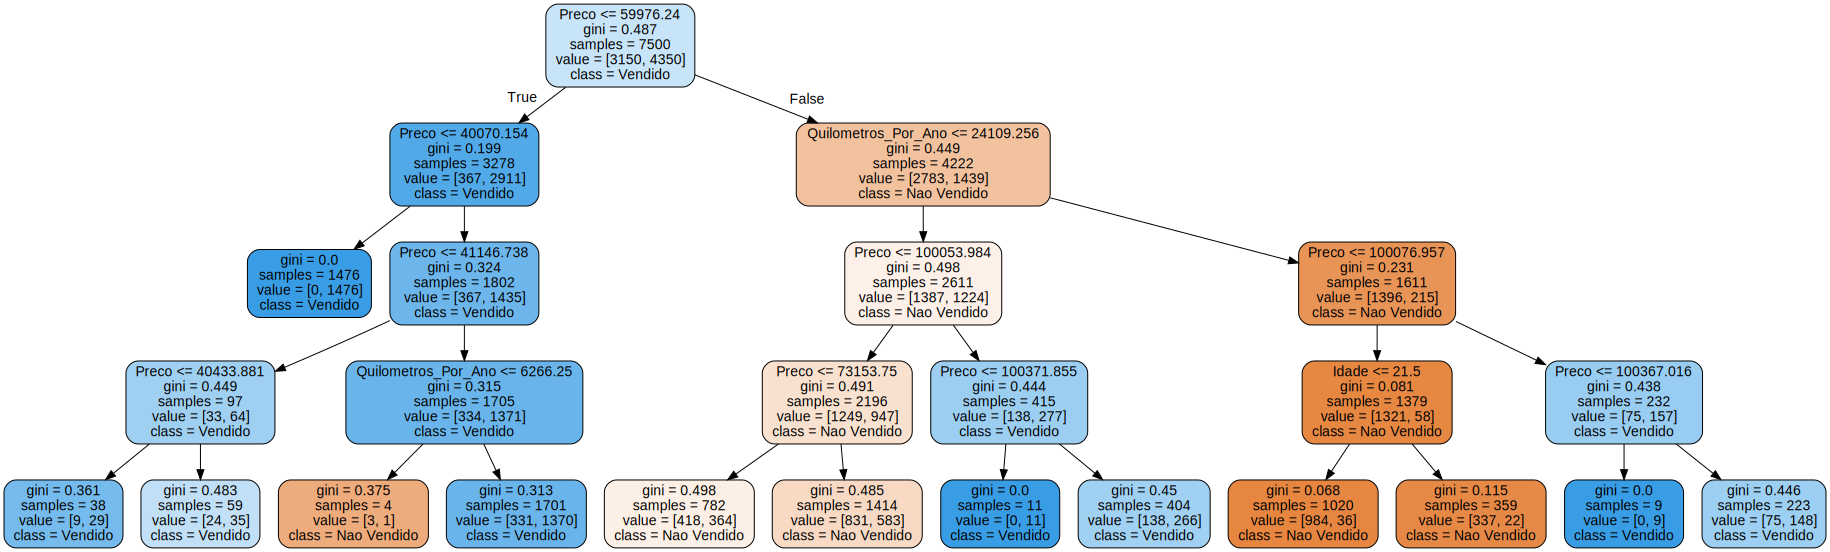

In [ ]:
dot_data = export_graphviz(modelo_arvore, out_file=None, feature_names = x.columns, filled = True, rounded = True, class_names = ["Nao Vendido", "Vendido"])
grafico_arvore = graphviz.Source(dot_data)
grafico_arvore

#Conclusão

- É um modelo intuitivo e simples de interpretar. Além disso, as árvores de decisão podem ser visualizadas.
- Não necessita de grandes pré-processamento de dados, como a normalização ou escalonamento de dados.
- Utiliza o modelo conhecido como caixa branca. Ou seja, as decisões que o modelo toma podem ser explicadas e interpretadas